<a href="https://colab.research.google.com/github/princessbethel/dissertation/blob/main/notebookdfa20988f2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

print('Data source import complete.')


Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Using Colab cache for faster access to the 'cremad' dataset.
Data source import complete.


In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [3]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,286 kB]
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,535 kB]
Fetched 4,950 kB in 3s (1,476 kB/s)
Reading pa

# Importing Data

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [4]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


# preprocessing

**Ravdees**

In [5]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [6]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [7]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
surprise    192
disgust     192
fear        192
sad         192
happy       192
calm        192
angry       192
neutral      96


/tmp/ipython-input-3389392308.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Integration**

In [8]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

In [9]:
print(data_path.Emotions.value_counts())


Emotions
surprise    192
disgust     192
fear        192
sad         192
happy       192
calm        192
angry       192
neutral      96
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

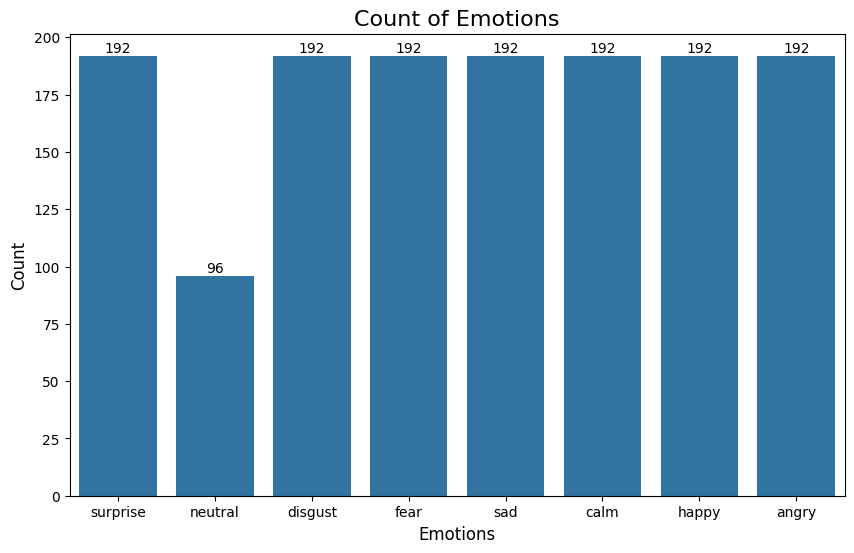

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the countplot
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
plt.title('Count of Emotions', size=16)
ax = sns.countplot(x="Emotions", data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Add counts above each bar
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Text is the height of the bar
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Coordinates
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

In [11]:
data,sr = librosa.load(file_path[1076])
sr

22050

In [12]:
ipd.Audio(data,rate=sr)

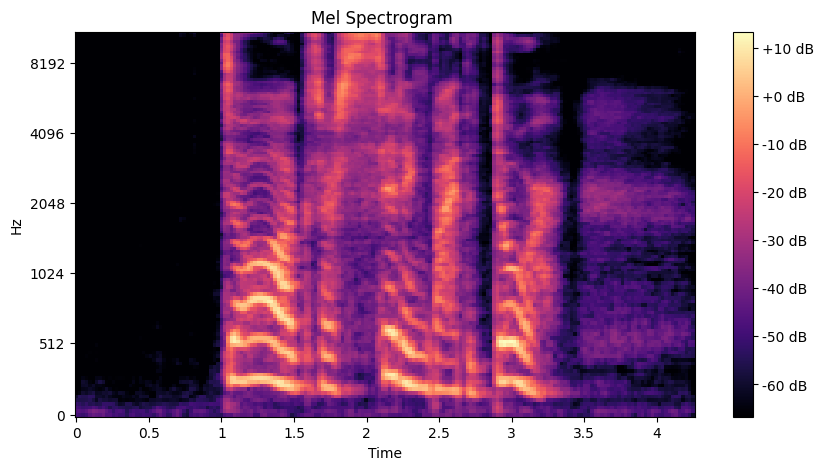

In [13]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

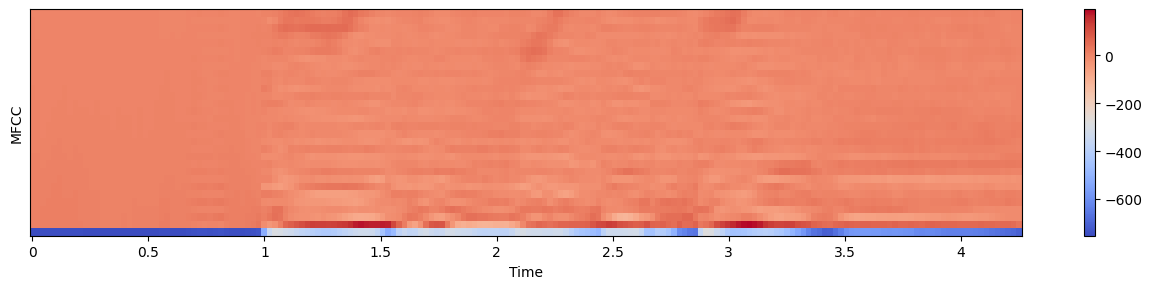

In [14]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [15]:
# NOISE
def noise(data):
    noise_amp = 0.043*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-3, high = 3)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.5):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

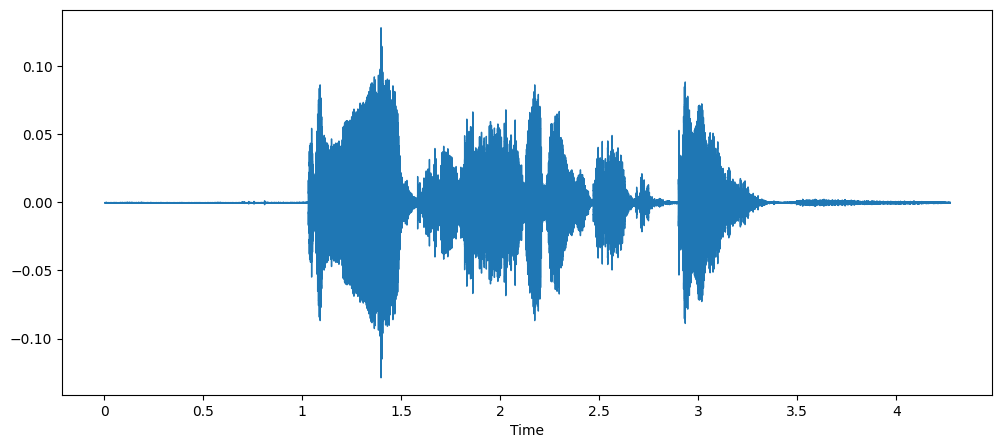

In [16]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

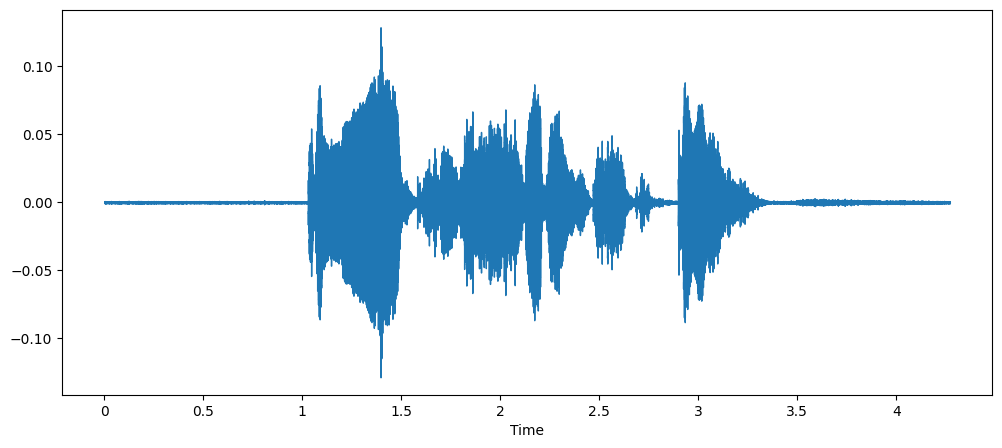

In [17]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [18]:
def pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)


# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

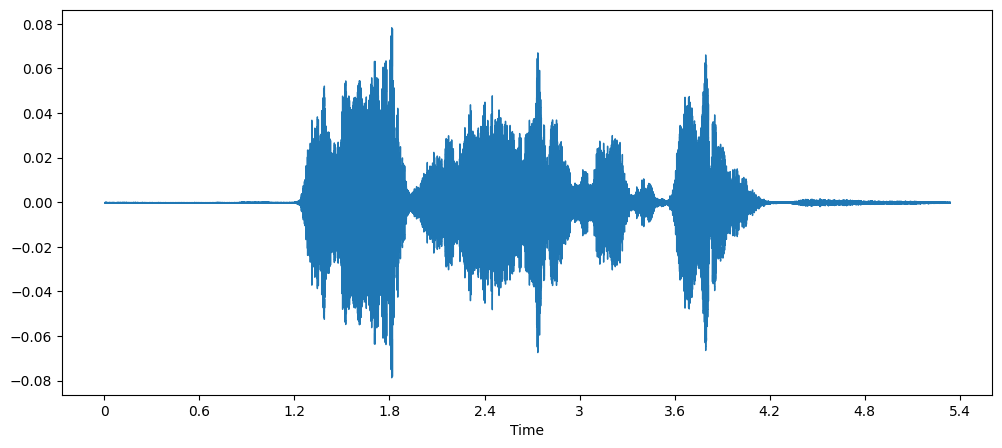

In [19]:
# STRETCHED AUDIO
#x = stretch(data)
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x)
ipd.Audio(x, rate=sr)

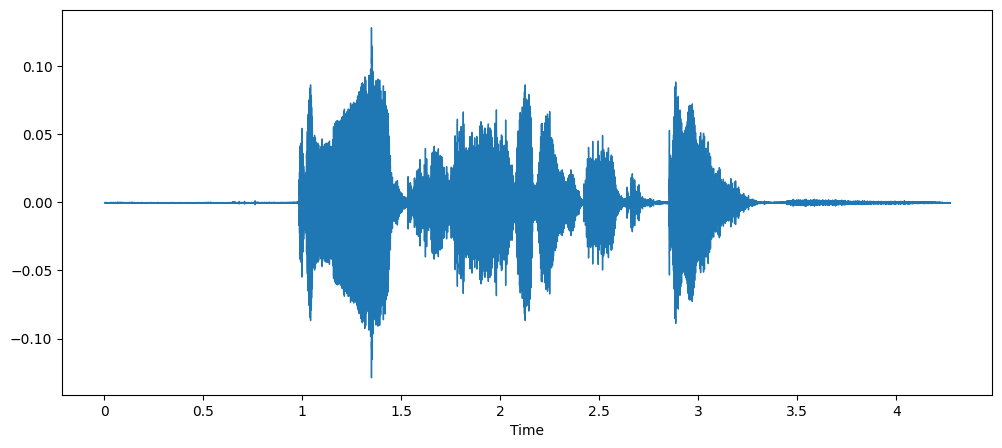

In [20]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

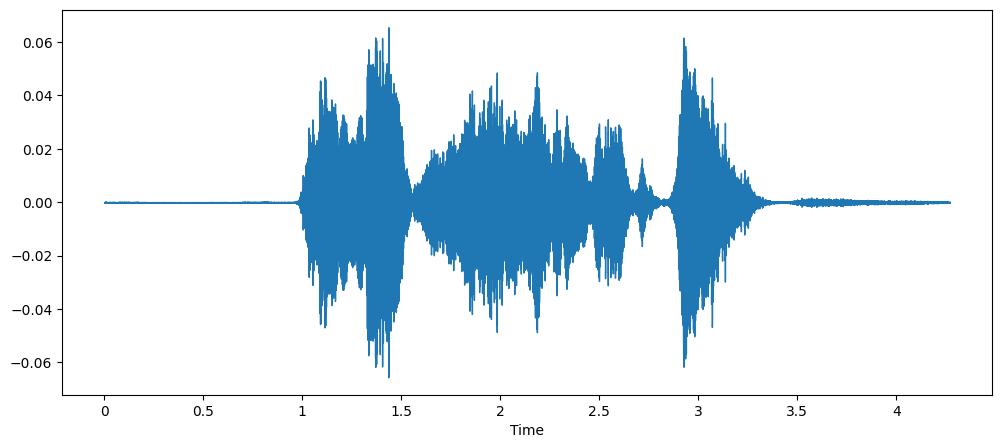

In [21]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [22]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    # Use `y=data` to specify the input audio signal
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])


    result=np.hstack((result,zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length) ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [23]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [24]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  5.84it/s]

0 audio has been processed


502it [01:08,  8.90it/s]

500 audio has been processed


1002it [02:13,  8.19it/s]

1000 audio has been processed


1440it [03:09,  7.60it/s]

Done
Time:  189.5833084400001


In [25]:
len(X), len(Y), data_path.Path.shape


(5760, 5760, (1440,))

# Saving features

In [26]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.253906  0.369629  0.491211  0.481445  0.481445  0.499512  0.501953   
2  0.316406  0.435547  0.553223  0.469727  0.387695  0.336426  0.288574   
3  0.257324  0.392090  0.507812  0.476074  0.444824  0.392090  0.354980   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.255371  0.251465  0.251953  ... -1.517691 -1.716481 -1.599312 -1.234615   
1  0.502930  0.500488  0.493652  ... -4.773300  2.866795  4.870544  2.473887   
2  0.278809  0.274414  0.280762  ...  1.678243  2.734655  3.698857  4.366373   
3  0.335938  0.338379  0.348633  ...  3.867464  3.072536  6.457696  6.083946   
4  0.827637  0.835938  0.667969  ...  2.586420  2.746858  2.223281  0.986924   

       2371      2372      2373      2374      2375  Emotions  
0 -0.693200 -0.038981  0.675205  1.405603  2.112302  surprise  
1  5.151570  1.935670 -0.993903 -3.338650 -6.754995  surprise  
2  4.678910  4.730829  4.683909  4.650658  4.628047  surprise  
3  3.750524 -1.245912  0.749587 -0.874118 -0.334850  surprise  
4 -0.730691 -2.530884 -4.002835 -4.849377 -4.929749   neutral  

[5 rows x 2377 columns]

In [27]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.253906  0.369629  0.491211  0.481445  0.481445  0.499512  0.501953   
2  0.316406  0.435547  0.553223  0.469727  0.387695  0.336426  0.288574   
3  0.257324  0.392090  0.507812  0.476074  0.444824  0.392090  0.354980   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.255371  0.251465  0.251953  ... -1.517691 -1.716481 -1.599312 -1.234615   
1  0.502930  0.500488  0.493652  ... -4.773300  2.866795  4.870544  2.473887   
2  0.278809  0.274414  0.280762  ...  1.678243  2.734655  3.698857  4.366373   
3  0.335938  0.338379  0.348633  ...  3.867464  3.072536  6.457696  6.083946   
4  0.827637  0.835938  0.667969  ...  2.586420  2.746858  2.223281  0.986924   

       2371      2372      2373      2374      2375  Emotions  
0 -0.693200 -0.038981  0.675205  1.405603  2.112302  surprise  
1  5.151570  1.935670 -0.993903 -3.338650 -6.754995  surprise  
2  4.678910  4.730829  4.683909  4.650658  4.628047  surprise  
3  3.750524 -1.245912  0.749587 -0.874118 -0.334850  surprise  
4 -0.730691 -2.530884 -4.002835 -4.849377 -4.929749   neutral  

[5 rows x 2377 columns]

In [28]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [29]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [30]:
np.sum(Emotions.isna())

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [31]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [32]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [33]:
print(Y.shape)
X.shape

(5760, 8)


(5760, 2376)

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=62,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [35]:
#reshape
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [36]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [37]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5.keras', monitor='val_accuracy', save_best_only=True)

In [39]:

early_stop=EarlyStopping(monitor='val_acc',mode='max',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.0001)

# CNN model

In [40]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((4608, 2376, 1), (4608, 8), (1152, 2376, 1), (1152, 8))

In [41]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import get as regularizer_get
from tensorflow.keras.constraints import get as constraint_get

class AttentionLayer(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = glorot_uniform()

        self.W_regularizer = regularizer_get(W_regularizer)
        self.b_regularizer = regularizer_get(b_regularizer)

        self.W_constraint = constraint_get(W_constraint)
        self.b_constraint = constraint_get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zeros',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True


    def compute_mask(self, input, input_mask=None):
        return None


    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [42]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(64,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 256)      │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 297, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,433,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,194,568 (12.19 MB)

 Trainable params: 3,192,648 (12.18 MB)

 Non-trainable params: 1,920 (7.50 KB)

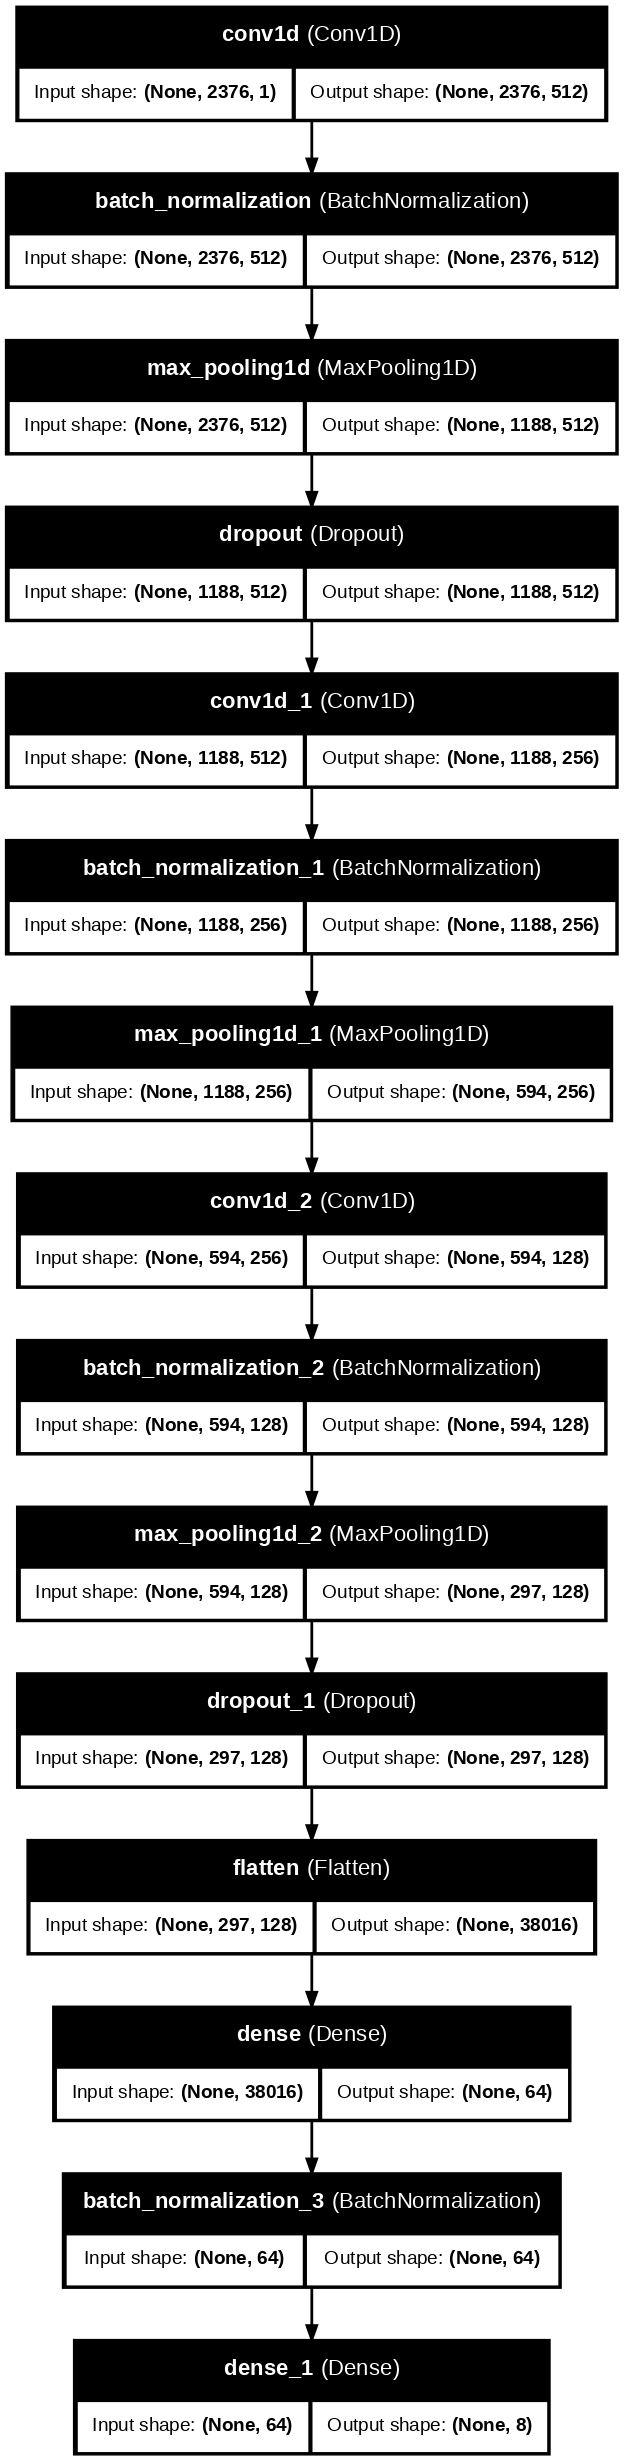

In [43]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already defined as `model`
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

In [44]:
history=model.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=128)
model_cnn = model

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 377ms/step - accuracy: 0.3475 - loss: 1.9497 - val_accuracy: 0.1198 - val_loss: 3.1400
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.6403 - loss: 1.0671 - val_accuracy: 0.1172 - val_loss: 4.4943
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.8113 - loss: 0.6219 - val_accuracy: 0.1189 - val_loss: 5.3226
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.9348 - loss: 0.3046 - val_accuracy: 0.1814 - val_loss: 3.8574
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.9840 - loss: 0.1417 - val_accuracy: 0.1441 - val_loss: 4.2482
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.9935 - loss: 0.0699 - val_accuracy: 0.1476 - val_loss: 4.7130
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.9973 - loss: 0.0371 - val_accuracy: 0.2378 - val_loss: 4.4328
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.9990 - loss: 0.0277 - 

Accuracy of CNN model on test data: 88.80%
Loss of CNN model on test data: 0.3822


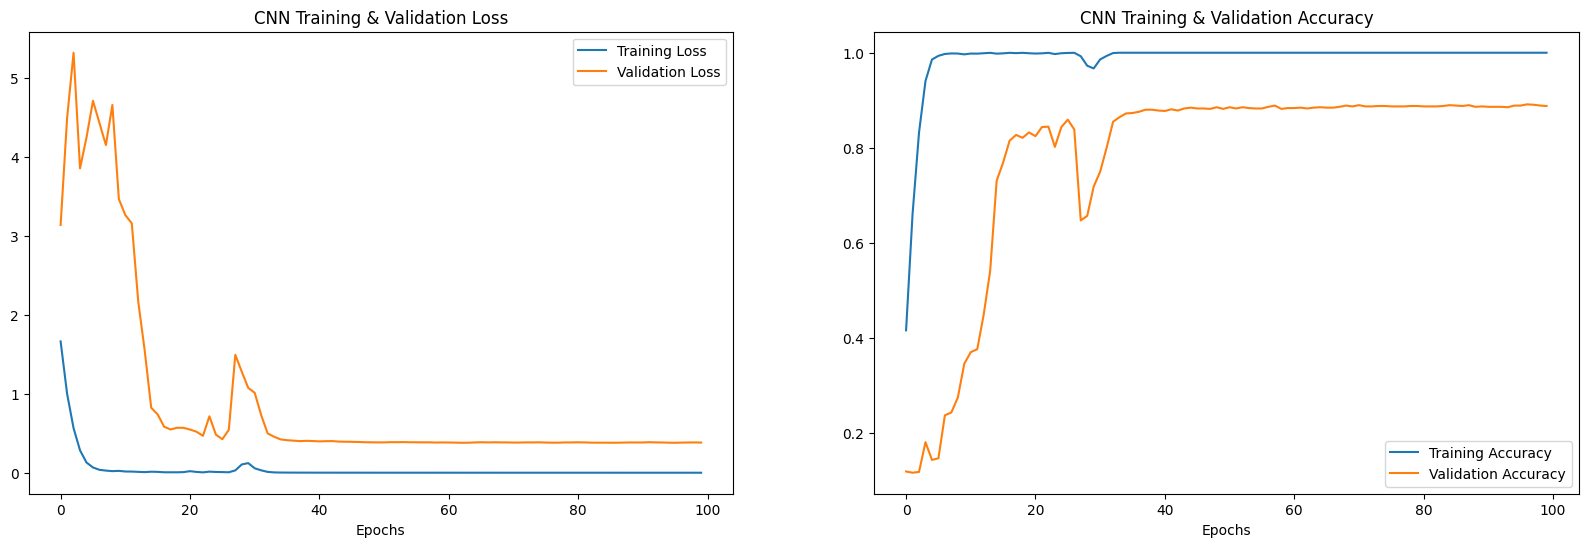

In [45]:
loss, acc = model.evaluate(x_testcnn, y_test, verbose=0)
print(f"Accuracy of CNN model on test data: {acc*100:.2f}%")
print(f"Loss of CNN model on test data: {loss:.4f}")

epochs = range(len(history.history['accuracy']))

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('CNN Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('CNN Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.show()


In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the labels on the test set
y_pred = model.predict(x_testcnn)

# Convert predictions and true labels to class labels (argmax for multi-class)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report (precision, recall, f1-score)
print("CNN Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=6))

# Print confusion matrix
print("CNN Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0   0.882353  0.925926  0.903614       162
           1   0.960784  0.924528  0.942308       159
           2   0.888889  0.920863  0.904594       139
           3   0.944828  0.815476  0.875399       168
           4   0.859873  0.859873  0.859873       157
           5   0.802632  0.938462  0.865248        65
           6   0.825175  0.874074  0.848921       135
           7   0.896341  0.880240  0.888218       167

    accuracy                       0.888021      1152
   macro avg   0.882609  0.892430  0.886022      1152
weighted avg   0.890843  0.888021  0.888191      1152

CNN Confusion Matrix:
[[150   0   6   1   4   0   1   0]
 [  0 147   0   1   0   6   5   0]
 [  6   2 128   0   0   0   2   1]
 [  5   1   2 137   7   1   6   9]
 [  6   0   1   1 135   2   8   4]
 [  0   1   0   0   0  61   2   1]
 [  0   2   5   2   2   4 118   2]
 [  3   0   2  

In [47]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Predicted Labels Actual Labels
0              sad           sad
1          neutral       neutral
2             fear          fear
3          neutral       neutral
4             fear          fear
5            happy         happy
6              sad           sad
7         surprise      surprise
8         surprise      surprise
9          disgust       disgust

In [48]:
df0.to_csv('cnn_predictions.csv', index=False)

In [49]:
emotion_names = data_path.Emotions.unique()
print(emotion_names)

['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry']


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


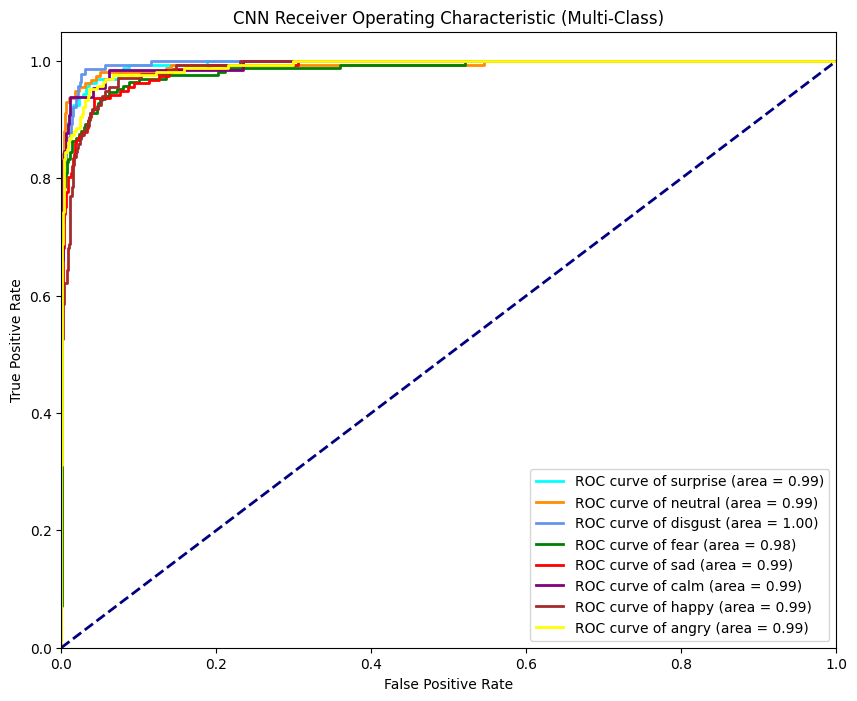

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming your class labels are: 'surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'
class_names = ['surprise', 'neutral', 'disgust', 'fear', 'sad', 'calm', 'happy', 'angry']
n_classes = len(class_names)

# Binarize the labels if y_test is not one-hot encoded
# y_test_bin should have shape (n_samples, n_classes) where each column corresponds to a class
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Get predicted probabilities from the model (y_pred should have shape (n_samples, n_classes))
# Assuming y_pred are probabilities for each class, e.g., output of the model's softmax layer
y_pred = model.predict(x_testcnn)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
# Use different colors for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'yellow']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (Multi-Class)')
plt.legend(loc='lower right')
plt.show()


# Evaluation

Results of best model

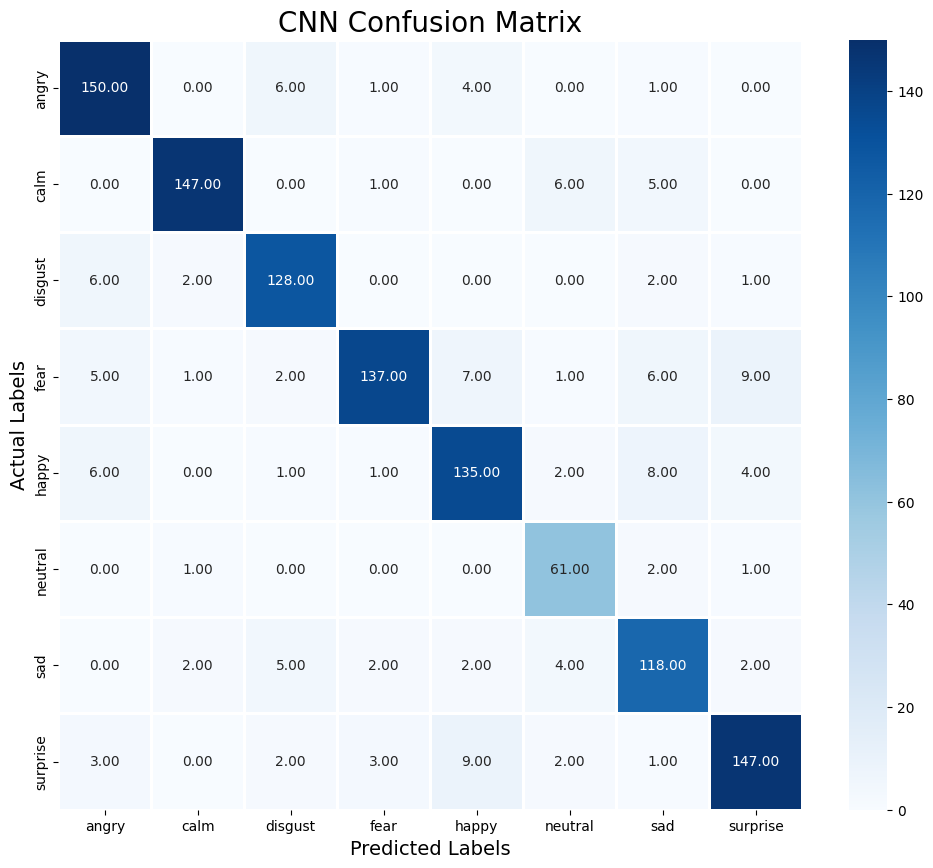

              precision    recall  f1-score   support

       angry       0.88      0.93      0.90       162
        calm       0.96      0.92      0.94       159
     disgust       0.89      0.92      0.90       139
        fear       0.94      0.82      0.88       168
       happy       0.86      0.86      0.86       157
     neutral       0.80      0.94      0.87        65
         sad       0.83      0.87      0.85       135
    surprise       0.90      0.88      0.89       167

    accuracy                           0.89      1152
   macro avg       0.88      0.89      0.89      1152
weighted avg       0.89      0.89      0.89      1152



In [51]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('CNN Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [52]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8805 - loss: 0.3862
compile_metrics: 88.80%


# Saving and Loading our Standard Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [54]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


# Test script
* That can predict new record

In [55]:
import pickle

with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [56]:
import librosa

In [57]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [58]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [59]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])

In [60]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
neutral


In [61]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
neutral


In [62]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
angry


In [63]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
sad


In [64]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
fear


In [65]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
surprise


In [66]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
disgust


## CNN+Transformer

In [67]:


import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dropout, GlobalAveragePooling1D, Dense, MultiHeadAttention, LayerNormalization, Add
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPool1D, Dropout, GlobalAveragePooling1D, Dense,
    MultiHeadAttention, LayerNormalization, Add, Input
)
from tensorflow.keras.models import Model

# Define the Transformer block
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Add & Normalize
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feedforward network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)

    # Add & Normalize
    output = Add()([attention_output, ff_output])
    output = LayerNormalization(epsilon=1e-6)(output)
    return output

# Input Layer
input_layer = Input(shape=(X_train.shape[1], 1))

# Convolutional Layers
x = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.2)(x)

x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)
x = Dropout(0.3)(x)

# Transformer Layer
x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=128, dropout_rate=0.1)

# Global Pooling and Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output_layer = Dense(8, activation='softmax')(x)

# Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2376, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2376, 512) │      3,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2376, 512) │      2,048 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1188, 512) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1188, 512) │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1188, 256) │    655,616 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1188, 256) │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 594, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 594, 128)  │     98,432 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 594, 128)  │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 297, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 297, 128)  │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 297, 128)  │     66,048 │ dropout_3[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 297, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 297, 128)  │          0 │ dropout_3[0][0],  │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 297, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 297, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 297, 128)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 297, 128)  │     16,512 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 297, 128)  │          0 │ layer_normalizat

 Total params: 869,320 (3.32 MB)

 Trainable params: 867,400 (3.31 MB)

 Non-trainable params: 1,920 (7.50 KB)

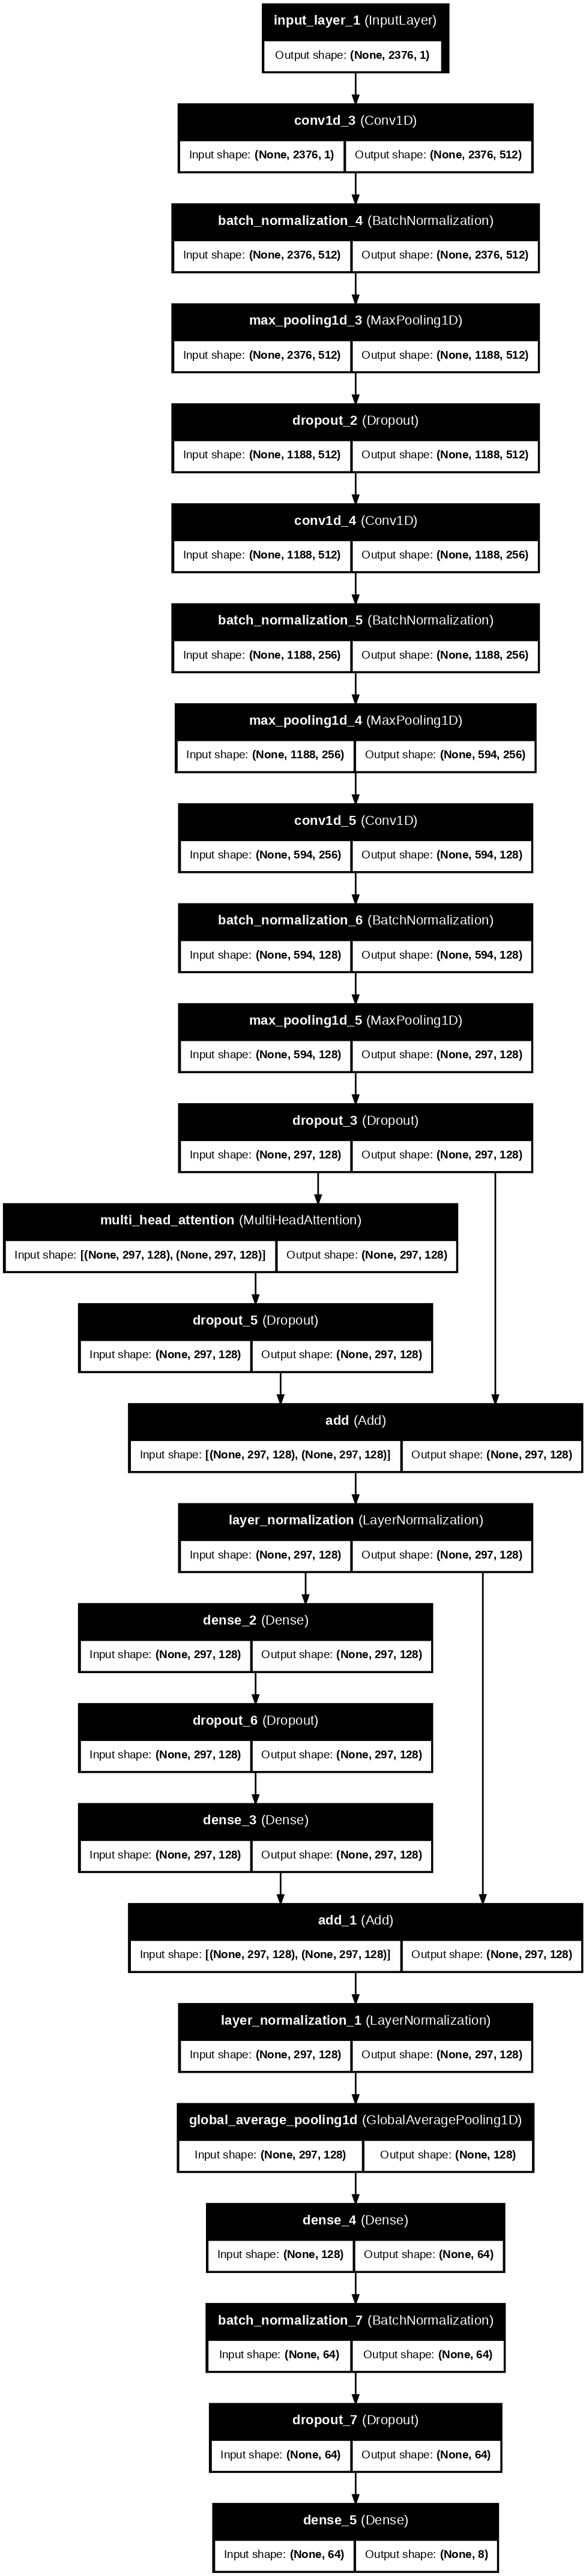

In [68]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already defined as `model`
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

In [69]:
history1=model.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=128)
model_transformer = model

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 355ms/step - accuracy: 0.1971 - loss: 2.3600 - val_accuracy: 0.1207 - val_loss: 2.4735
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.3160 - loss: 1.8764 - val_accuracy: 0.1363 - val_loss: 2.5319
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.3513 - loss: 1.7247 - val_accuracy: 0.0651 - val_loss: 2.7547
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.3983 - loss: 1.6068 - val_accuracy: 0.1415 - val_loss: 2.4609
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.4157 - loss: 1.5341 - val_accuracy: 0.1233 - val_loss: 2.8774
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.4484 - loss: 1.4770 - val_accuracy: 0.1198 - val_loss: 3.0555
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.4830 - loss: 1.4073 - val_accuracy: 0.1545 - val_loss: 2.6397
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.4961 - loss: 1.3723 - 

Accuracy of CNN+Transformer model on test data: 74.13%
Loss of CNN+Transformer model on test data: 1.3571


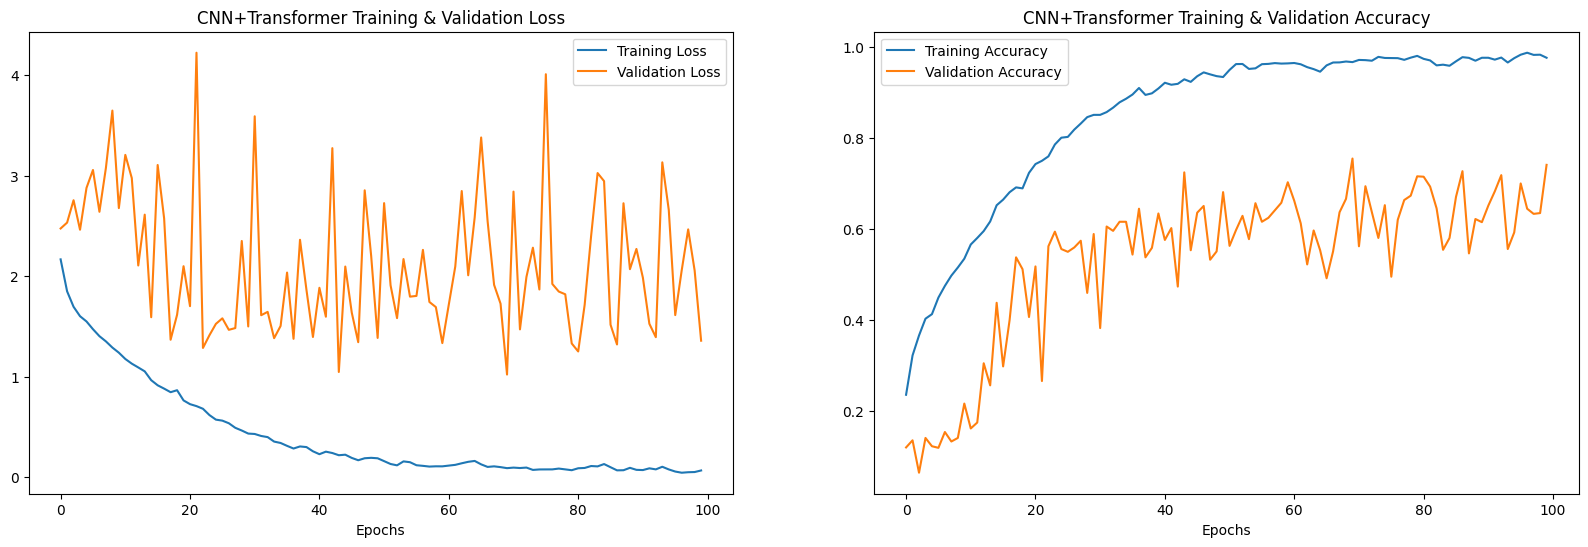

In [70]:
# Evaluate model ONCE
loss_tf, acc_tf = model.evaluate(x_testcnn, y_test, verbose=0)
print(f"Accuracy of CNN+Transformer model on test data: {acc_tf*100:.2f}%")
print(f"Loss of CNN+Transformer model on test data: {loss_tf:.4f}")

# Use the real epoch count
epochs_tf = range(len(history1.history['accuracy']))

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
test_acc = history1.history['val_accuracy']
test_loss = history1.history['val_loss']

# Loss Curve
ax[0].plot(epochs_tf, train_loss, label='Training Loss')
ax[0].plot(epochs_tf, test_loss, label='Validation Loss')
ax[0].set_title('CNN+Transformer Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

# Accuracy Curve
ax[1].plot(epochs_tf, train_acc, label='Training Accuracy')
ax[1].plot(epochs_tf, test_acc, label='Validation Accuracy')
ax[1].set_title('CNN+Transformer Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.show()


In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the labels on the test set
y_pred = model.predict(x_testcnn)

# Convert predictions and true labels to class labels (argmax for multi-class)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=6))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0   0.904000  0.697531  0.787456       162
           1   0.856250  0.861635  0.858934       159
           2   0.682353  0.834532  0.750809       139
           3   0.688235  0.696429  0.692308       168
           4   0.741259  0.675159  0.706667       157
           5   0.682540  0.661538  0.671875        65
           6   0.590909  0.770370  0.668810       135
           7   0.813793  0.706587  0.756410       167

    accuracy                       0.741319      1152
   macro avg   0.744917  0.737973  0.736659      1152
weighted avg   0.754758  0.741319  0.743088      1152

Confusion Matrix:
[[113   2  26   4   8   1   3   5]
 [  0 137   3   1   1   4  13   0]
 [  3   1 116   3   6   0   9   1]
 [  6   1   5 117  12   3  16   8]
 [  2   5   2  16 106   1  15  10]
 [  0   7   0   1   1  43  12   1]
 [  0   6   4  13   4   2 104   2]
 [  1   1  14  15   5  

In [72]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)
df0.to_csv('transformer_predictions.csv', index=False)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


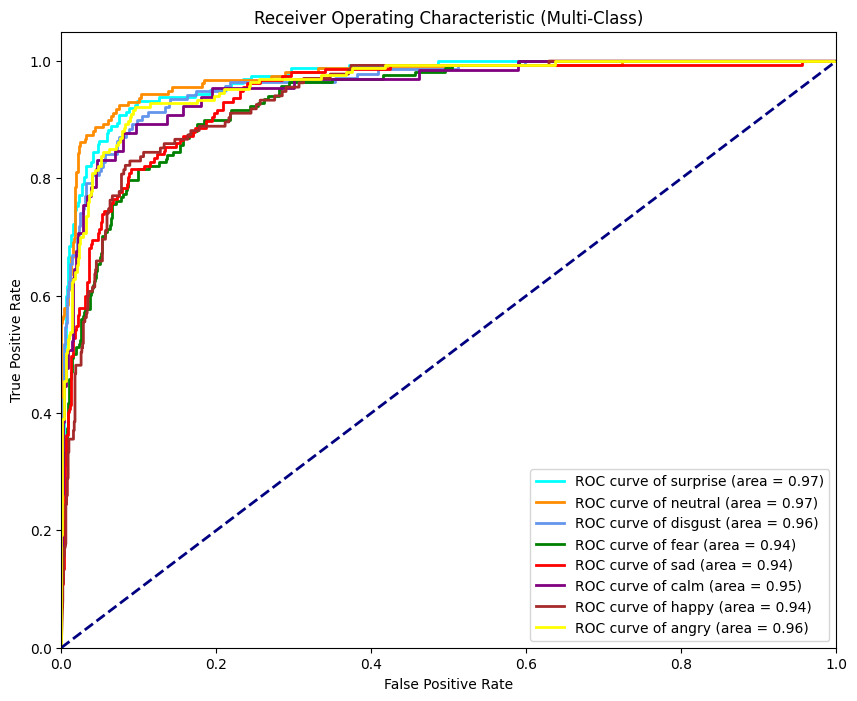

In [73]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming your class labels are: 'surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'
class_names = ['surprise', 'neutral', 'disgust', 'fear', 'sad', 'calm', 'happy', 'angry']
n_classes = len(class_names)

# Binarize the labels if y_test is not one-hot encoded
# y_test_bin should have shape (n_samples, n_classes) where each column corresponds to a class
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Get predicted probabilities from the model (y_pred should have shape (n_samples, n_classes))
# Assuming y_pred are probabilities for each class, e.g., output of the model's softmax layer
y_pred = model.predict(x_testcnn)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
# Use different colors for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'yellow']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-Class)')
plt.legend(loc='lower right')
plt.show()


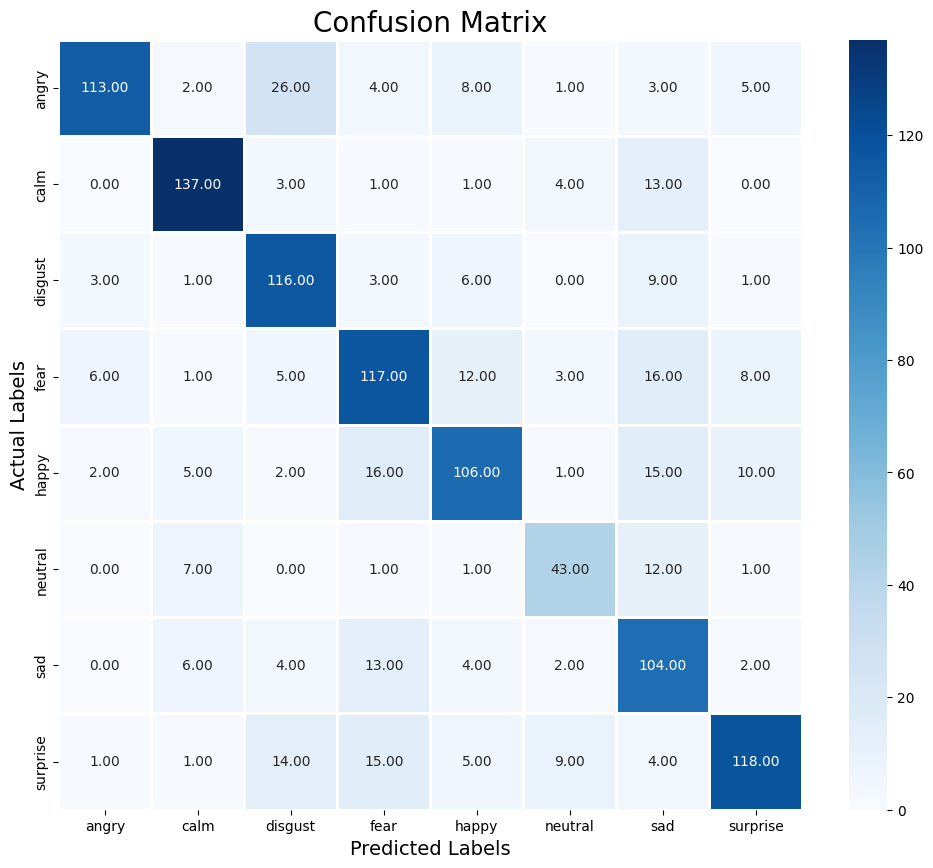

              precision    recall  f1-score   support

       angry       0.90      0.70      0.79       162
        calm       0.86      0.86      0.86       159
     disgust       0.68      0.83      0.75       139
        fear       0.69      0.70      0.69       168
       happy       0.74      0.68      0.71       157
     neutral       0.68      0.66      0.67        65
         sad       0.59      0.77      0.67       135
    surprise       0.81      0.71      0.76       167

    accuracy                           0.74      1152
   macro avg       0.74      0.74      0.74      1152
weighted avg       0.75      0.74      0.74      1152



In [74]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

## DNN

In [75]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.models import Sequential

# Define the DNN model
model = Sequential([
    # Input layer (Flatten the input if needed)
    Flatten(input_shape=(X_train.shape[1], 1)),

    # Fully connected (Dense) layers

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),

    # Output layer (softmax for multi-class classification)
    Dense(8, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       608,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,976 (2.49 MB)

 Trainable params: 651,080 (2.48 MB)

 Non-trainable params: 896 (3.50 KB)

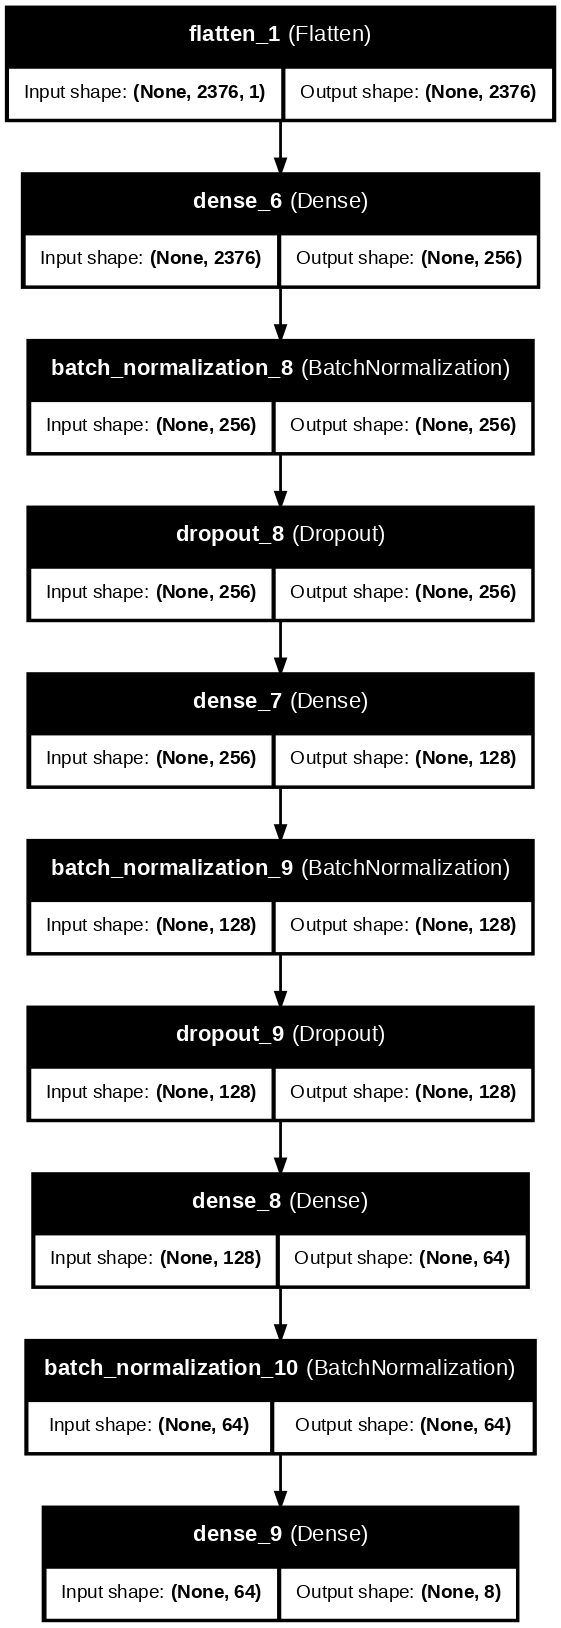

In [76]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already defined as `model`
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

In [77]:
history2=model.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=128)
model_dnn = model



Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3486 - loss: 1.9084 - val_accuracy: 0.4974 - val_loss: 1.4332
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7051 - loss: 0.9176 - val_accuracy: 0.6745 - val_loss: 0.9717
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8347 - loss: 0.5442 - val_accuracy: 0.7639 - val_loss: 0.7424
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9138 - loss: 0.3278 - val_accuracy: 0.8177 - val_loss: 0.5813
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9557 - loss: 0.2163 - val_accuracy: 0.8385 - val_loss: 0.5128
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.1525 - val_accuracy: 0.8429 - val_loss: 0.4673
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9765 - loss: 0.1151 - val_accuracy: 0.8707 - val_loss: 0.3848
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9903 - loss: 0.0714 - val_accuracy: 0.8776 - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8900 - loss: 0.4996
Accuracy of DNN model on test data :  89.14930820465088 %
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8900 - loss: 0.4996
Loss of DNN model on test data :  0.510168731212616


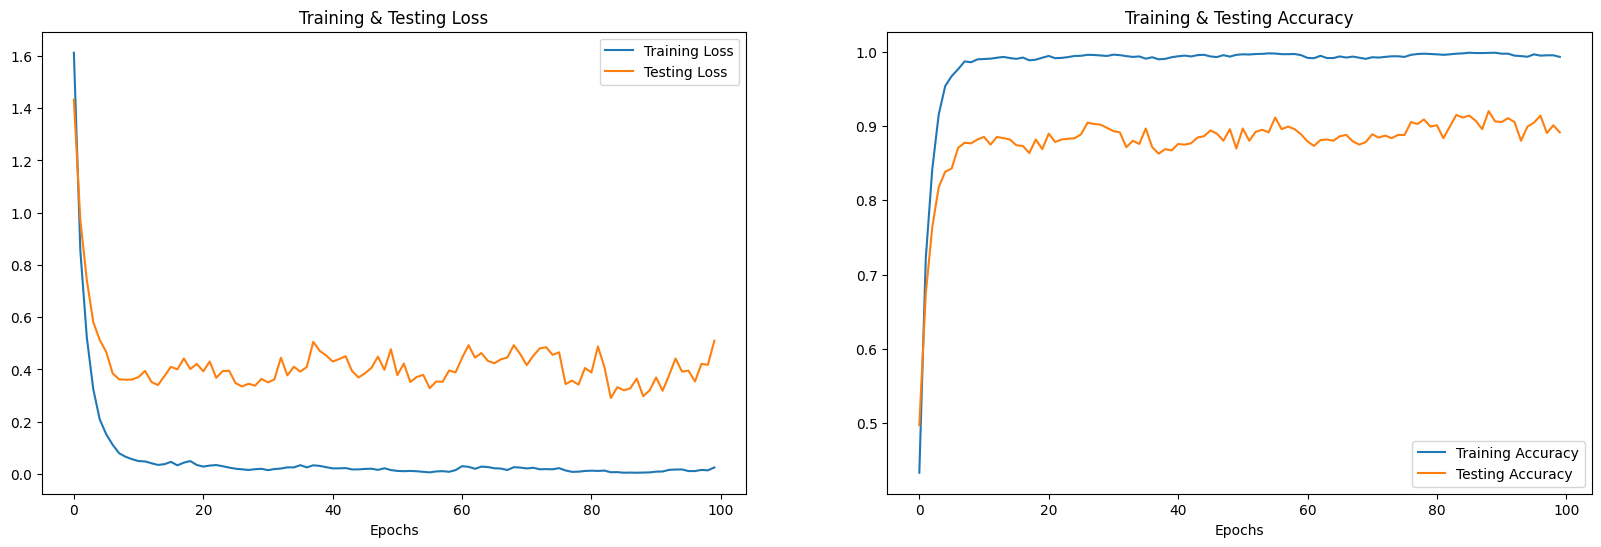

In [78]:
print("Accuracy of DNN model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")
print("Loss of DNN model on test data : " , model.evaluate(x_testcnn,y_test)[0])
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
test_acc = history2.history['val_accuracy']
test_loss = history2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [79]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the labels on the test set
y_pred = model.predict(x_testcnn)

# Convert predictions and true labels to class labels (argmax for multi-class)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=6))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0   0.861111  0.956790  0.906433       162
           1   0.881657  0.937107  0.908537       159
           2   0.898551  0.892086  0.895307       139
           3   0.886905  0.886905  0.886905       168
           4   0.929577  0.840764  0.882943       157
           5   0.814286  0.876923  0.844444        65
           6   0.869231  0.837037  0.852830       135
           7   0.954839  0.886228  0.919255       167

    accuracy                       0.891493      1152
   macro avg   0.887020  0.889230  0.887082      1152
weighted avg   0.893454  0.891493  0.891411      1152

Confusion Matrix:
[[155   1   2   2   1   0   1   0]
 [  0 149   3   0   0   2   5   0]
 [ 11   0 124   0   0   1   2   1]
 [  2   2   3 149   5   2   4   1]
 [  8   0   1   6 132   5   1   4]
 [  0   5   0   1   0  57   2   0]
 [  1  10   3   2   2   3 113   1]
 [  3   2   2   8   2   

In [80]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)
df0.to_csv('dnn_predictions.csv', index=False)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


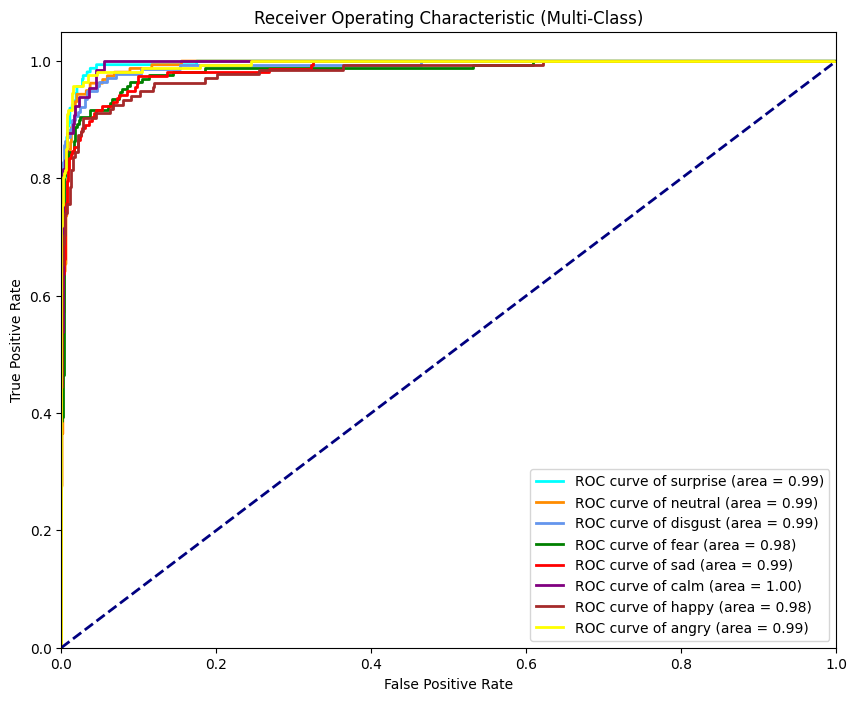

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming your class labels are: 'surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'
class_names = ['surprise', 'neutral', 'disgust', 'fear', 'sad', 'calm', 'happy', 'angry']
n_classes = len(class_names)

# Binarize the labels if y_test is not one-hot encoded
# y_test_bin should have shape (n_samples, n_classes) where each column corresponds to a class
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Get predicted probabilities from the model (y_pred should have shape (n_samples, n_classes))
# Assuming y_pred are probabilities for each class, e.g., output of the model's softmax layer
y_pred = model.predict(x_testcnn)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
# Use different colors for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'yellow']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-Class)')
plt.legend(loc='lower right')
plt.show()


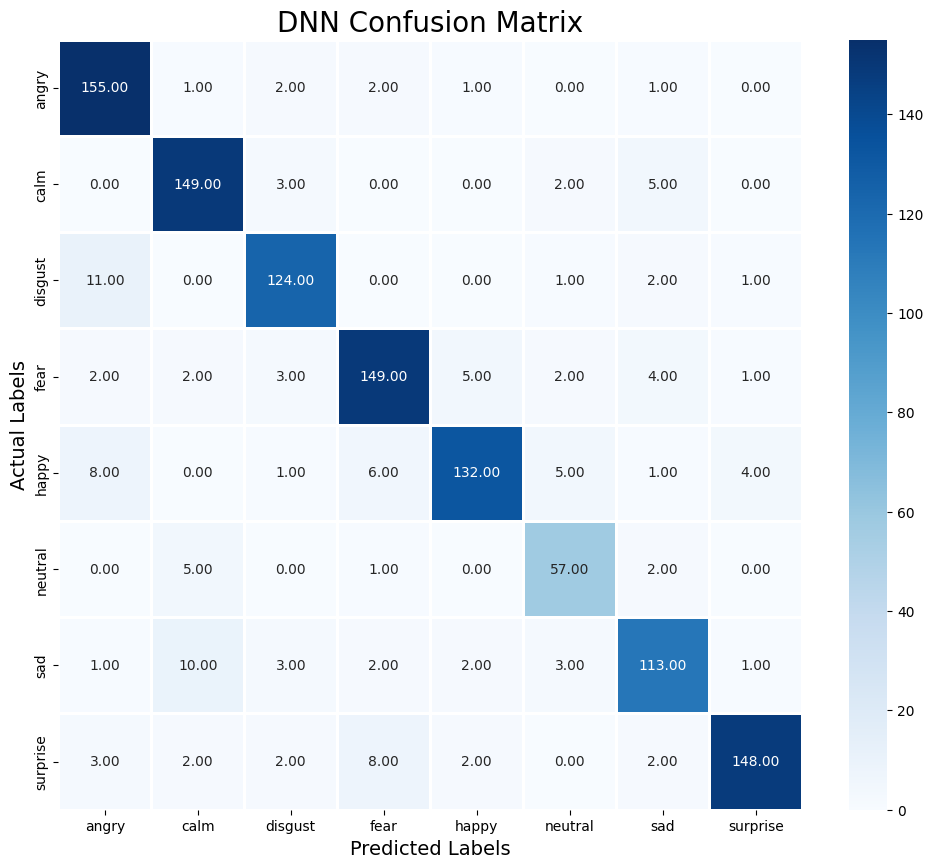

              precision    recall  f1-score   support

       angry       0.86      0.96      0.91       162
        calm       0.88      0.94      0.91       159
     disgust       0.90      0.89      0.90       139
        fear       0.89      0.89      0.89       168
       happy       0.93      0.84      0.88       157
     neutral       0.81      0.88      0.84        65
         sad       0.87      0.84      0.85       135
    surprise       0.95      0.89      0.92       167

    accuracy                           0.89      1152
   macro avg       0.89      0.89      0.89      1152
weighted avg       0.89      0.89      0.89      1152



In [82]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('DNN Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ensemble Accuracy: 91.41%
              precision    recall  f1-score   support

       angry       0.87      0.94      0.91       162
        calm       0.93      0.97      0.95       159
     disgust       0.88      0.93      0.91       139
        fear       0.91      0.89      0.90       168
       happy       0.95      0.89      0.92       157
     neutral       0.90      0.94      0.92        65
         sad       0.89      0.89      0.89       135
    surprise       0.97      0.88      0.92       167

    accuracy                           0.91      1152
   macro avg       0.91      0.92      0.91      1152
weighted avg       0.92      0.91      0.91      1152



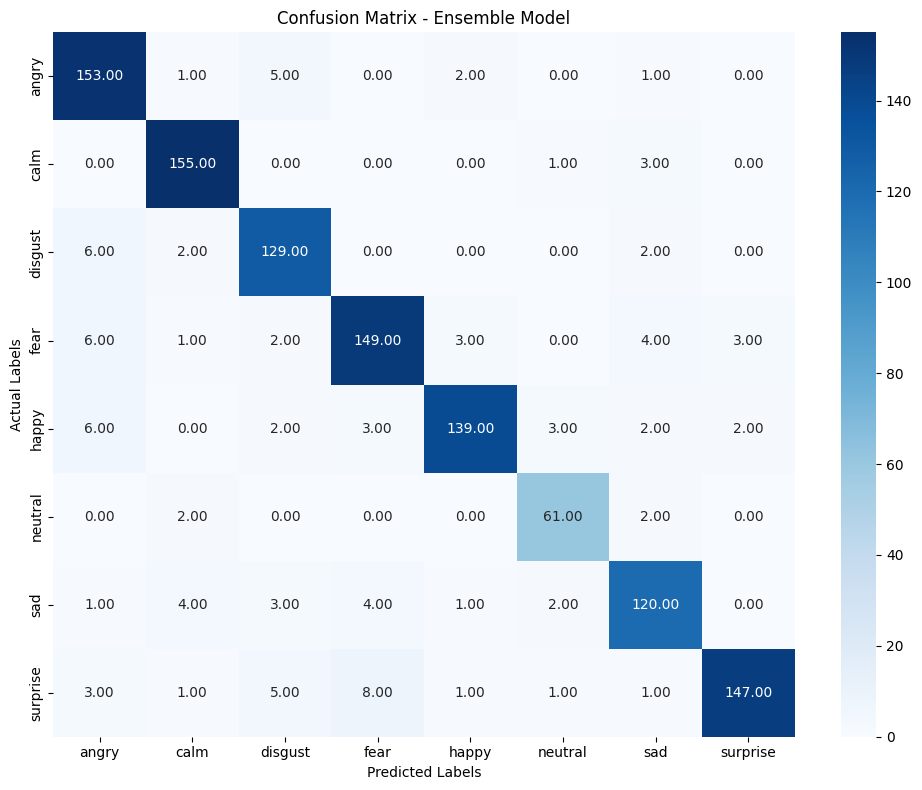

In [83]:
# ENSEMBLE - Majority Voting
import numpy as np
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
pred_cnn = np.argmax(model_cnn.predict(x_testcnn), axis=1)
pred_transformer = np.argmax(model_transformer.predict(x_testcnn), axis=1)
pred_dnn = np.argmax(model_dnn.predict(x_testcnn), axis=1)

# Majority voting
all_predictions = np.stack([pred_cnn, pred_dnn, pred_transformer], axis=1)
ensemble_pred, _ = stats.mode(all_predictions, axis=1, keepdims=False)
ensemble_pred = ensemble_pred.flatten()

# True labels
y_true = np.argmax(y_test, axis=1)

# Results
print(f"Ensemble Accuracy: {np.mean(ensemble_pred == y_true) * 100:.2f}%")

class_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print(classification_report(y_true, ensemble_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.tight_layout()
plt.show()

Shapes (should all be: [N, 8]):
 CNN:         (1152, 8)
 Transformer: (1152, 8)
 DNN:         (1152, 8)

Accuracy of ENSEMBLE (CNN + Transformer + DNN) on test data: 92.45%



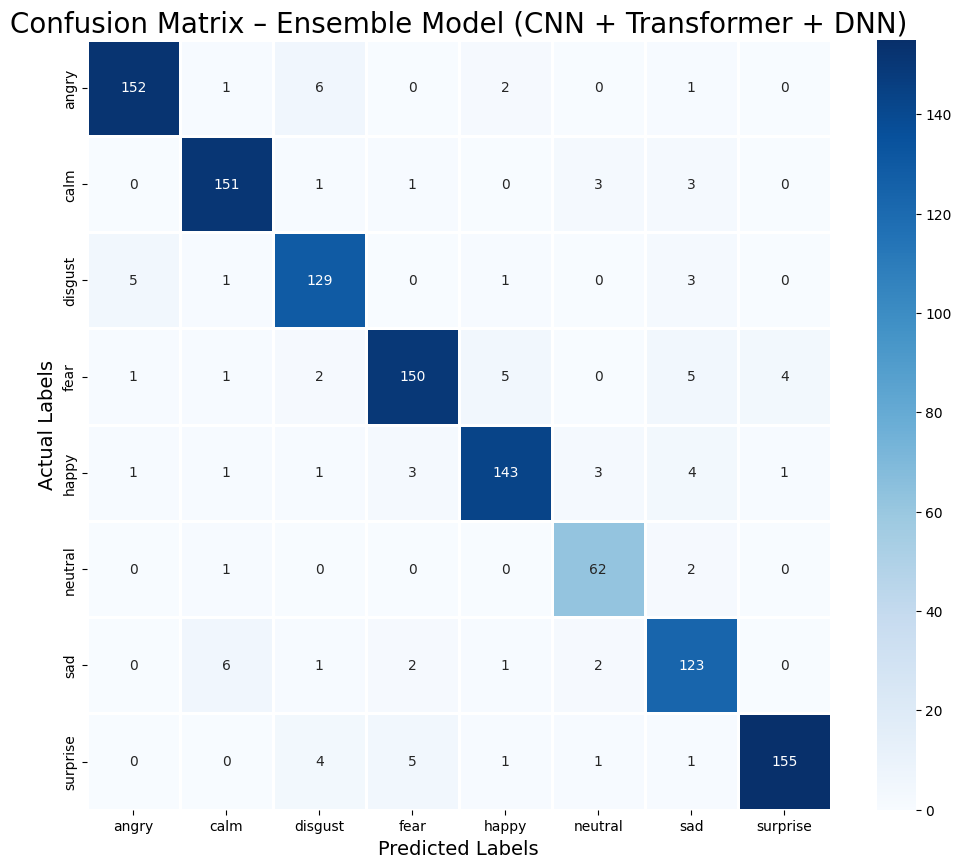

Classification Report – Ensemble Model

              precision    recall  f1-score   support

       angry       0.96      0.94      0.95       162
        calm       0.93      0.95      0.94       159
     disgust       0.90      0.93      0.91       139
        fear       0.93      0.89      0.91       168
       happy       0.93      0.91      0.92       157
     neutral       0.87      0.95      0.91        65
         sad       0.87      0.91      0.89       135
    surprise       0.97      0.93      0.95       167

    accuracy                           0.92      1152
   macro avg       0.92      0.93      0.92      1152
weighted avg       0.93      0.92      0.92      1152



In [84]:
# ============================================================
# ENSEMBLE: CNN + TRANSFORMER + DNN  (RAVDESS only, same test set)
# Uses:
#   model_cnn         - your first CNN model
#   model_transformer - your CNN+Transformer model
#   model_dnn         - your DNN model
#   x_testcnn         - test features (N, 2376, 1)
#   y_test            - one-hot test labels (N, 8)
#   encoder           - OneHotEncoder fitted on emotion labels
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---------- 1. Predict class probabilities with each model ----------
proba_cnn         = model_cnn.predict(x_testcnn,        verbose=0)
proba_transformer = model_transformer.predict(x_testcnn, verbose=0)
proba_dnn         = model_dnn.predict(x_testcnn,        verbose=0)

print("Shapes (should all be: [N, 8]):")
print(" CNN:        ", proba_cnn.shape)
print(" Transformer:", proba_transformer.shape)
print(" DNN:        ", proba_dnn.shape)

# ---------- 2. Simple probability averaging ----------
proba_ensemble = (proba_cnn + proba_transformer + proba_dnn) / 3.0

# Hard labels (indices)
y_true_idx = np.argmax(y_test, axis=1)
y_pred_idx = np.argmax(proba_ensemble, axis=1)

# Overall accuracy
acc_ens = (y_true_idx == y_pred_idx).mean() * 100.0
print(f"\nAccuracy of ENSEMBLE (CNN + Transformer + DNN) on test data: {acc_ens:.2f}%\n")

# ---------- 3. Convert to string labels for confusion matrix ----------
# encoder.categories_[0] is something like:
# ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
emotion_labels = encoder.categories_[0]

# Strings for ground truth and predictions
y_true_str = encoder.inverse_transform(y_test).ravel()
y_pred_str = encoder.inverse_transform(proba_ensemble).ravel()

# Confusion matrix with consistent label order
cm_ens = confusion_matrix(y_true_str, y_pred_str, labels=emotion_labels)

cm_ens_df = pd.DataFrame(cm_ens,
                         index=emotion_labels,
                         columns=emotion_labels)

# ---------- 4. Plot confusion matrix EXACTLY like your CNN/DNN ----------
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_ens_df,
    linecolor='white',
    cmap='Blues',
    linewidth=1,
    annot=True,
    fmt='d'   # use 'd' for integer counts; change to '.2f' if you want decimals
)
plt.title('Confusion Matrix – Ensemble Model (CNN + Transformer + DNN)', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# ---------- 5. Classification report ----------
print("Classification Report – Ensemble Model\n")
print(classification_report(y_true_str, y_pred_str, target_names=emotion_labels))


/tmp/ipython-input-844821620.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


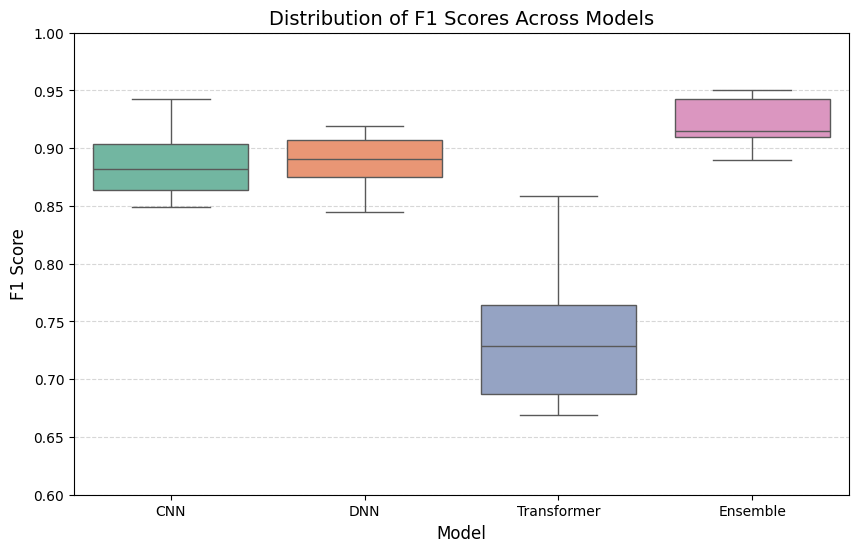

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# FINAL F1 VALUES USED IN DISSERTATION
f1_scores = {
    "CNN": [
        0.9036, 0.9423, 0.9046, 0.8754,
        0.8599, 0.8652, 0.8489, 0.8882
    ],
    "DNN": [
        0.9064, 0.9085, 0.8953, 0.8869,
        0.8829, 0.8444, 0.8528, 0.9193
    ],
    "Transformer": [
        0.7875, 0.8589, 0.7508, 0.6923,
        0.7067, 0.6719, 0.6688, 0.7564
    ],
    "Ensemble": [
        0.95, 0.94, 0.91, 0.91,
        0.92, 0.91, 0.89, 0.95
    ]
}

df = (
    pd.DataFrame(f1_scores)
    .melt(var_name="Model", value_name="F1 Score")
)

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x="Model",
    y="F1 Score",
    palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]  # similar to your theme
)

plt.title("Distribution of F1 Scores Across Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0.60, 1.00)  # clean scale
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()
